In [1]:
!pip install -q xgboost imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('/content/drive/MyDrive/techsophy/survey.csv')
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
df.dropna(inplace=True)

label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
24,0,33,12,2,1,0,1,1,2,2,...,0,1,1,2,2,1,2,0,0,64
25,1,35,12,2,17,0,1,1,3,5,...,4,2,1,1,2,1,2,1,0,67
33,2,42,7,2,22,0,1,1,3,2,...,4,0,1,1,1,0,2,0,0,23
45,3,38,3,2,18,0,1,1,3,2,...,2,1,1,1,2,1,1,2,0,60
49,4,30,12,2,4,0,1,1,2,2,...,0,0,1,1,2,1,1,0,0,20


In [7]:

print(df.columns)

X = df.drop('treatment', axis=1)
y = df['treatment']

Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')


In [8]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [10]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Initial Accuracy: 0.9259259259259259

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.88      0.94        17

    accuracy                           0.93        27
   macro avg       0.92      0.94      0.92        27
weighted avg       0.94      0.93      0.93        27



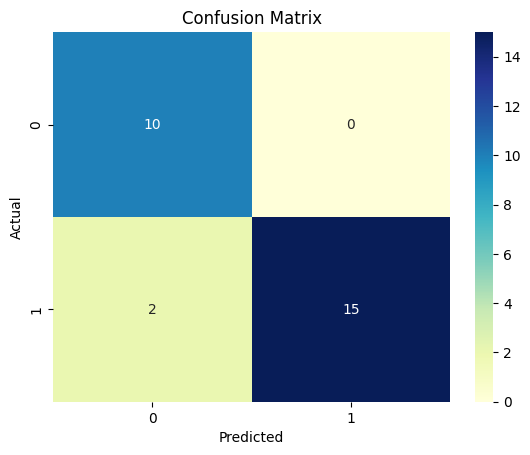

In [11]:
print("Initial Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [12]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
y_pred_tuned = best_model.predict(X_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Tuned Accuracy: 0.8888888888888888

Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.82      0.90        17

    accuracy                           0.89        27
   macro avg       0.88      0.91      0.89        27
weighted avg       0.91      0.89      0.89        27



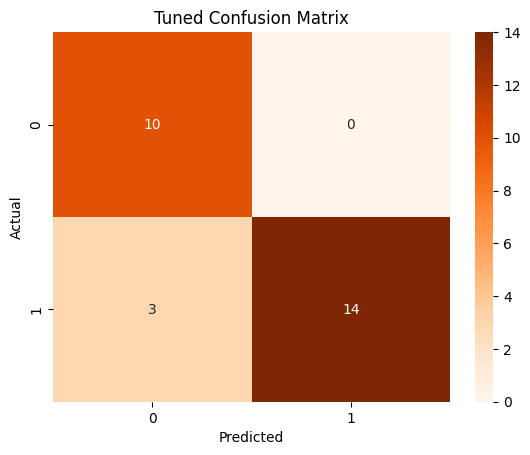

In [13]:
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nTuned Classification Report:\n", classification_report(y_test, y_pred_tuned))

sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Oranges')
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
def assess_risk(pred):
    return "⚠️ High Risk: Recommend seeking help or mental health support" if pred == 1 else "Low Risk✅"

sample = X_test.iloc[0:1]
prediction = best_model.predict(sample)[0]
print("Risk Prediction:", assess_risk(prediction))


Risk Prediction: Low Risk✅
